```mermaid
flowchart LR

classDef notebook fill:#5c7fa6,stroke:#3f5a7b,color:#f2f6fb, font-weight:bold;
classDef python fill:#9a80b8,stroke:#6d5789,color:#f7f3fb, font-weight:bold;
classDef files fill:#7fc9aa,stroke:#549578,color:#0f2f1f;
classDef tools fill:#e9c48a,stroke:#b58950,color:#2d1c05;

N05C["05_ethnicity_clusters.ipynb"]:::notebook

N05C --> Glue["metadata/build_master.py"]:::python

Glue --> Files["Parquet Outputs:<br>attributes.parquet<br>attributes_with_meta.parquet<br>attributes_with_clusters.parquet"]:::files

Files --> Tools78["Tools:<br>polars<br>parquet I/O"]:::tools


In [1]:
import os, sys

# 1) Set notebook working directory = FaceStats project root
PROJECT_ROOT = "/Users/jayklarin/__DI/Repositories/FaceStats"
os.chdir(PROJECT_ROOT)
print("cwd:", os.getcwd())

# 2) Add src/ folder to Python PATH
SRC_PATH = os.path.join(PROJECT_ROOT, "src")
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

print("src path added:", SRC_PATH)


cwd: /Users/jayklarin/__DI/Repositories/FaceStats
src path added: /Users/jayklarin/__DI/Repositories/FaceStats/src


### Step 14 — Ethnicity Clustering (Embedding Space Exploration)

In this step, we examine whether the CLIP embeddings show natural clustering related to *ethnicity*.

Even though only ~200 images currently have manual labels, this step is still valuable:
- PCA/TSNE can show natural grouping in embedding space
- Partial labels help us visualize which clusters correspond to which groups
- This step does *not* require complete labeling

We will:
1. Load CLIP embeddings (`data/processed/embeddings/embeddings_clip.parquet`)
2. Load cleaned attribute table (`data/processed/metadata/attributes_final.parquet`)
3. Merge on filename  
4. Compute **PCA (2D)**  
5. Plot points colored by `ethnicity_final`


In [2]:
import polars as pl
import numpy as np

EMB = "data/processed/embeddings/embeddings_clip.parquet"
ATTR = "data/processed/metadata/attributes_final.parquet"

df_emb = pl.read_parquet(EMB)
df_attr = pl.read_parquet(ATTR)

print("Embeddings:", df_emb.shape)
print("Attributes:", df_attr.shape)

# Merge on filename
df = df_emb.join(df_attr, on="filename", how="inner")
print("Merged:", df.shape)

df.head()


Embeddings: (31396, 2)
Attributes: (31396, 5)
Merged: (31396, 6)


filename,embedding,age,gender_final,ethnicity_final,attractiveness
str,list[f64],null,str,str,f32
"""SFHQ_pt4_00034620.jpg""","[0.047166, -0.01974, … -0.01318]",null,"""female""","""white""",null
"""SFHQ_pt4_00107598.jpg""","[0.027307, -0.066495, … 0.012836]",null,"""unknown""","""white""",null
"""SFHQ_pt4_00072675.jpg""","[0.038216, -0.017191, … 0.008944]",null,"""unknown""","""unknown""",null
"""SFHQ_pt4_00086092.jpg""","[0.040853, -0.001176, … -0.034655]",null,"""unknown""","""unknown""",null
"""SFHQ_pt4_00065309.jpg""","[0.030933, 0.005503, … 0.001794]",null,"""female""","""unknown""",null


In [3]:
from sklearn.decomposition import PCA
# TSNE optional (slow): from sklearn.manifold import TSNE

# Convert embedding column → numpy matrix
X = np.vstack(df["embedding"].to_list())

# PCA 2D projection
pca = PCA(n_components=2)
xy = pca.fit_transform(X)

print("PCA done. Shape:", xy.shape)

df_p = df.with_columns([
    pl.Series("x", xy[:,0]),
    pl.Series("y", xy[:,1])
])

df_p.head()


PCA done. Shape: (31396, 2)


filename,embedding,age,gender_final,ethnicity_final,attractiveness,x,y
str,list[f64],null,str,str,f32,f64,f64
"""SFHQ_pt4_00034620.jpg""","[0.047166, -0.01974, … -0.01318]",null,"""female""","""white""",null,0.021488,-0.002685
"""SFHQ_pt4_00107598.jpg""","[0.027307, -0.066495, … 0.012836]",null,"""unknown""","""white""",null,-0.306311,0.015361
"""SFHQ_pt4_00072675.jpg""","[0.038216, -0.017191, … 0.008944]",null,"""unknown""","""unknown""",null,-0.114593,0.007097
"""SFHQ_pt4_00086092.jpg""","[0.040853, -0.001176, … -0.034655]",null,"""unknown""","""unknown""",null,0.026862,0.132271
"""SFHQ_pt4_00065309.jpg""","[0.030933, 0.005503, … 0.001794]",null,"""female""","""unknown""",null,-0.304162,0.011569


Filtered rows: (31396, 8)


/var/folders/gz/0c41mw6j22x4rm3rkhgx2_3h0000gn/T/ipykernel_85615/3250197584.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", len(unique_eth))


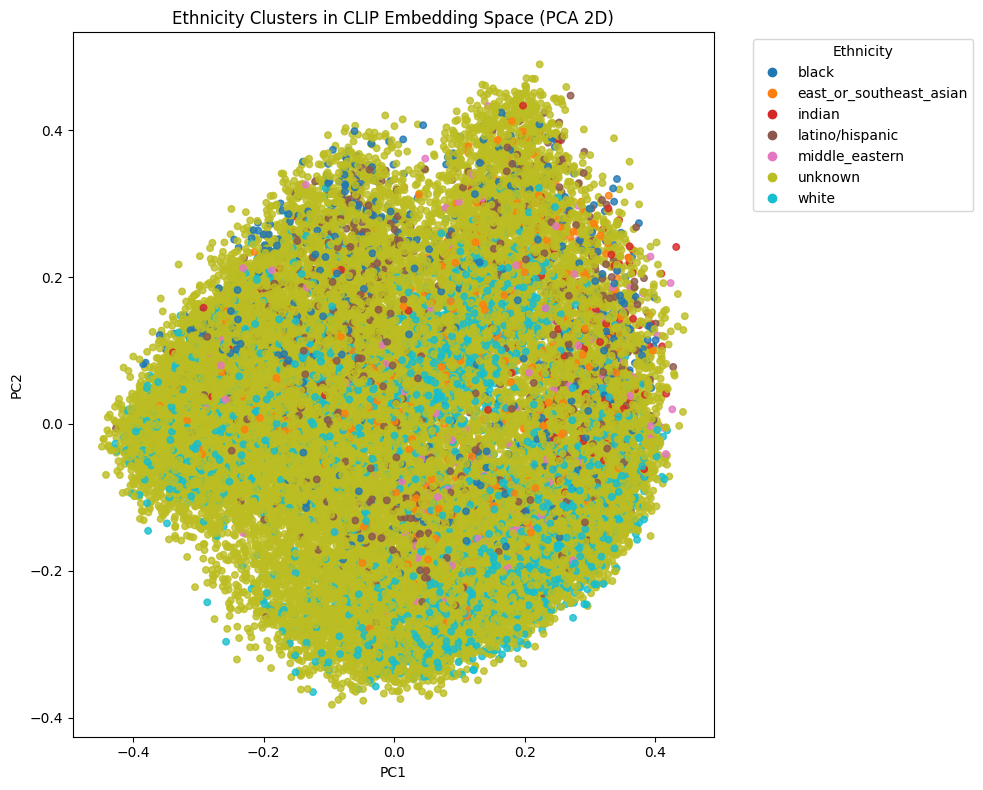

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import polars as pl
from matplotlib.cm import get_cmap

# ------------------------------------------------------
# 1. Filter out any rows with missing PCA coordinates
# ------------------------------------------------------
df_plot = df_p.filter(
    (pl.col("x").is_not_null()) &
    (pl.col("y").is_not_null())
)

print("Filtered rows:", df_plot.shape)

# ------------------------------------------------------
# 2. Extract plotting arrays
# ------------------------------------------------------
x = df_plot["x"].to_numpy()
y = df_plot["y"].to_numpy()
eth = df_plot["ethnicity_final"].to_list()

# ------------------------------------------------------
# 3. Build a categorical colormap safely
# ------------------------------------------------------
unique_eth = sorted(df_plot["ethnicity_final"].unique().to_list())

# Assign each ethnicity a numeric index
eth_to_idx = {eth: i for i, eth in enumerate(unique_eth)}

# Convert to numeric list for Matplotlib
color_values = np.array([eth_to_idx[e] for e in eth])

# Build an actual colormap with N distinct colors
cmap = get_cmap("tab10", len(unique_eth))

# ------------------------------------------------------
# 4. Plot
# ------------------------------------------------------
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    x,
    y,
    c=color_values,
    cmap=cmap,
    s=22,
    alpha=0.8
)

plt.title("Ethnicity Clusters in CLIP Embedding Space (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# ------------------------------------------------------
# 5. Build a proper legend
# ------------------------------------------------------
handles = []
for eth_label, idx in eth_to_idx.items():
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            color=cmap(idx),
            linestyle="",
            label=eth_label
        )
    )

plt.legend(
    handles=handles,
    title="Ethnicity",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


### Notes & Next Steps

- Only ~200 images currently have manual ethnicity labels.
- The classifier is trained only on those 200, so unlabeled images appear as `unknown`.
- This step still shows useful clustering structure.
- Later, after labeling more images, this plot will become far more informative.

**Next Steps:**
- Label more images using the labeling app for improved classifier accuracy.
- Re-train the ethnicity classifier (Step 8).
- Re-run this notebook to see cleaner clusters.
